# Feature engineering

In this notebook different features of the signals will be created to evaluate their predictive power.

## Extracting features out of the frequency analysis

The idea is to obtain the decomposition of the signal into different frequency ranges using a wavelet decomposition. This process will result in a signal for each band of interest. From this signal we will take common statistical features to include in the dataset.

Using an 8-level wavelet decomposition, the signal is decomposed into 9 coefficients each of which represent a different frequency band: 

| Coefficient   |	Frequency Band (Hz) |   Name on this project   |  
|---------------|-----------------------|-----------|   
|   cA8        |   0 to 97.6           |    band 0  |
|   cD8        |   97.5 to 195.3       |    band 1  |
|   cD7        |   195.3 to 390.6       |   band 2  |
|   cD6        |    390.6	to 781.25  |    band 3  |
|   cD5        |	781.25 to 	1,562.5 |   band 4  |
|   cD4        |	1,562.5 to 	3,125   |   band 5  |
|   cD3        |	3,125 to	6,250   |   band 6  |
|   cD2        |	6,250 to	12,500 |    band 7  |
|   cD1        |	12,500 to	25,000 |    band 8  |

As we are not interested in frequencies below 1000 Hz, we will only keep coefficients cD5-8 and cA8. That means that we now have 5 new signals for each sensor signal. Out of each of these, we will extract the following features:

* min
* max
* mean
* std
* skew
* kurtosis
* energy
* entropy
* zero crossings

This will add a total of (7 signals) x (5 bands) x (9 features) = 315 new features to the dataset.

In [1]:
import pandas as pd
import pywt
import numpy as np
from scipy.stats import skew, kurtosis, entropy
import os

# Silences pandas warning that ruin the display of the notebook on github
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
def frequency_feature_extraction(file_path):
    df = pd.read_csv(file_path,sep=',')
    df.columns = ['force_x', 'force_y', 'force_z', 'vibration_x', 'vibration_y', 'vibration_z', 'ae_rms']
    df_features = pd.DataFrame()
    for column in df.columns:
        coeffs = pywt.wavedec(df[column], 'db4', level=8)
        for i, coeff in enumerate(coeffs[0:5]):
            df_features[column+"_band_"+str(i)+"_min"] = [np.min(coeff)]
            df_features[column+"_band_"+str(i)+"_max"] = [np.max(coeff)]
            df_features[column+"_band_"+str(i)+"_mean"] = [np.mean(coeff)]
            df_features[column+"_band_"+str(i)+"_std"] = [np.std(coeff)]
            df_features[column+"_band_"+str(i)+"_skew"] = [skew(coeff)]
            df_features[column+"_band_"+str(i)+"_kurtosis"] = [kurtosis(coeff)]
            df_features[column+"_band_"+str(i)+"_energy"] = [np.sum(np.square(coeff))]
            df_features[column+"_band_"+str(i)+"_entropy"] = [entropy(np.abs(coeff)/np.sum(coeff))]
            df_features[column+"_band_"+str(i)+"_zero_crossings"] = [np.sum(np.diff(np.sign(coeff)) != 0)]
    return df_features

In [3]:
folder_path = "../data/raw/c1/c1/"

df_list = []

for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
        df_list.append(frequency_feature_extraction(folder_path + filename))

df_features_full = pd.concat(df_list, ignore_index=True)

In [4]:
df_features_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Columns: 315 entries, force_x_band_0_min to ae_rms_band_4_zero_crossings
dtypes: float64(280), int64(35)
memory usage: 775.3 KB


In [5]:
total_nulls = df_features_full.isnull().sum().sum()
total_nulls

0

In [6]:
df_features_full.head(10)

,force_x_band_0_min,force_x_band_0_max,force_x_band_0_mean,force_x_band_0_std,force_x_band_0_skew,force_x_band_0_kurtosis,force_x_band_0_energy,force_x_band_0_entropy,force_x_band_0_zero_crossings,force_x_band_1_min,...,ae_rms_band_3_zero_crossings,ae_rms_band_4_min,ae_rms_band_4_max,ae_rms_band_4_mean,ae_rms_band_4_std,ae_rms_band_4_skew,ae_rms_band_4_kurtosis,ae_rms_band_4_energy,ae_rms_band_4_entropy,ae_rms_band_4_zero_crossings
0,3.372719,15.569993,6.491647,1.207309,2.083674,12.079730,2.197394e+04,6.206558,0,-17.765534,...,1263,-0.003087,0.002905,-0.000012,0.000750,0.148335,0.173608,0.002242,7.991690,2476
1,-5.805412,20.314628,16.309406,2.434481,-4.949676,34.993954,2.324945e+05,6.741197,1,-36.196235,...,2278,-0.006229,0.017295,0.000023,0.001936,1.052757,3.416955,0.025474,8.425849,4374
2,0.016538,34.157013,28.199037,3.886272,-5.133151,30.621197,6.968483e+05,6.742305,0,-50.144802,...,2273,-0.009216,0.021860,0.000030,0.002584,0.879653,2.244280,0.045633,8.505429,4478
3,-4.159454,39.454248,33.396989,4.699173,-5.830109,38.341714,9.793368e+05,6.744745,2,-46.989103,...,2282,-0.017264,0.031650,0.000003,0.003155,0.941339,3.642558,0.068113,8.495699,4525
4,-9.086499,49.627350,44.925053,5.568968,-6.944627,53.071132,1.770573e+06,6.752766,1,-46.250601,...,2282,-0.013142,0.020719,-0.000002,0.003228,0.693154,1.824094,0.071532,8.495760,4521
5,0.642277,52.892650,46.582083,5.177832,-6.671886,47.613727,1.891359e+06,6.748746,0,-53.411202,...,2281,-0.012825,0.018548,0.000008,0.003316,0.520278,0.746841,0.075248,8.515262,4491
6,3.461129,56.643208,47.957654,5.356083,-6.118930,41.075058,2.007274e+06,6.750307,0,-44.045124,...,2285,-0.019224,0.025315,-0.000006,0.003917,0.789764,2.114131,0.105091,8.479461,4523
7,2.752090,54.774813,49.164788,5.560055,-6.588877,45.394000,2.110254e+06,6.749694,0,-46.370354,...,2280,-0.024442,0.023989,-0.000053,0.004457,0.518128,2.241059,0.136066,8.450354,4519
8,0.988779,50.143963,43.178691,4.798676,-5.698681,39.077524,1.632624e+06,6.753938,0,-43.730588,...,2285,-0.015497,0.025776,0.000078,0.003725,0.932226,2.620129,0.095414,8.497825,4518
9,0.582495,49.433335,42.754358,5.015991,-6.137055,40.434369,1.597368e+06,6.749060,0,-41.501057,...,2270,-0.016286,0.025621,0.000060,0.003897,0.882034,2.184111,0.103996,8.482616,4479


A quick way of checking if some of the features are redundant is to cluster the features based on how correlated they are, this can be done creating a clustermap of the correlation matrix:

In [7]:
corr_matrix = df_features_full.corr()

/home/dave/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 3000x3000 with 0 Axes>

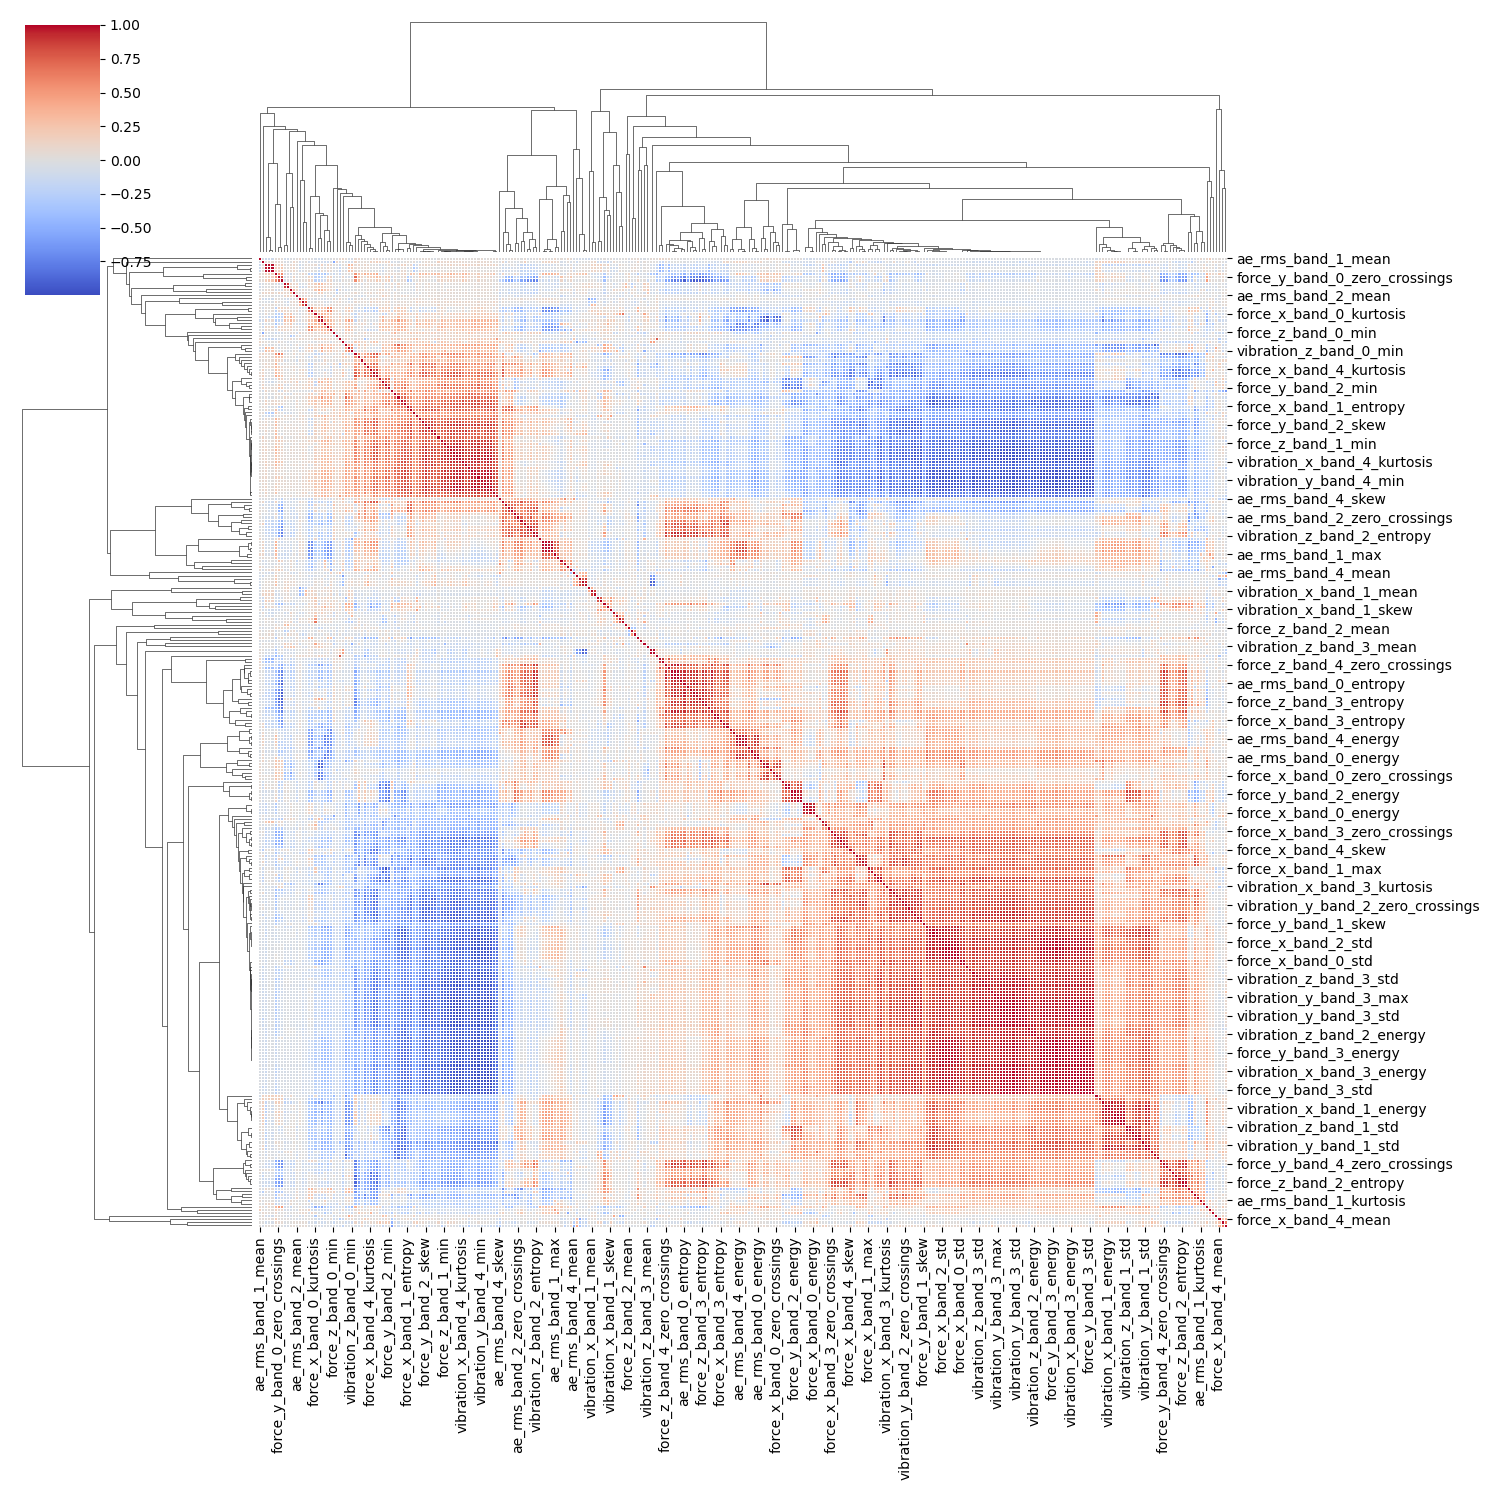

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
sns.clustermap(corr_matrix, metric='correlation', method='average' ,cmap='coolwarm', linewidths=0.5, figsize=(15, 15))

plt.show()

There are is one big cluster and some smaller ones of highly correlated feature. This indicates we might be able to avoid redundancy by reducing the amount of features we consider. 

## Principal Component Analysis

This method takes our features and calculates a new set of features that are uncorrelated to each other. By choosing from these new features the ones that explain the variance of the data better, we can reduce the amount of features to consider.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features_full)

In [11]:
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

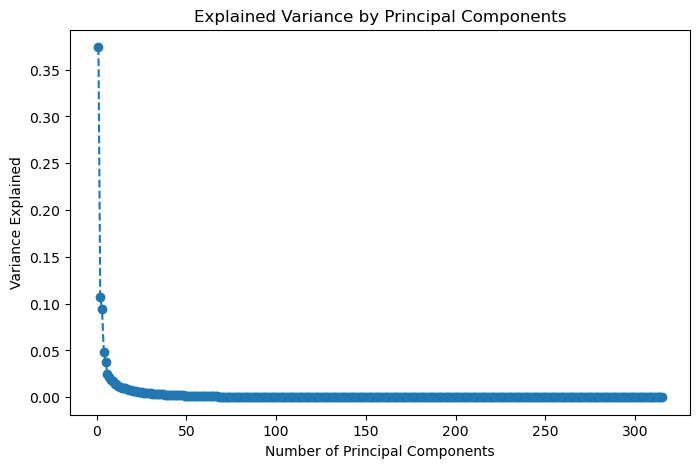

In [12]:
# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.show()

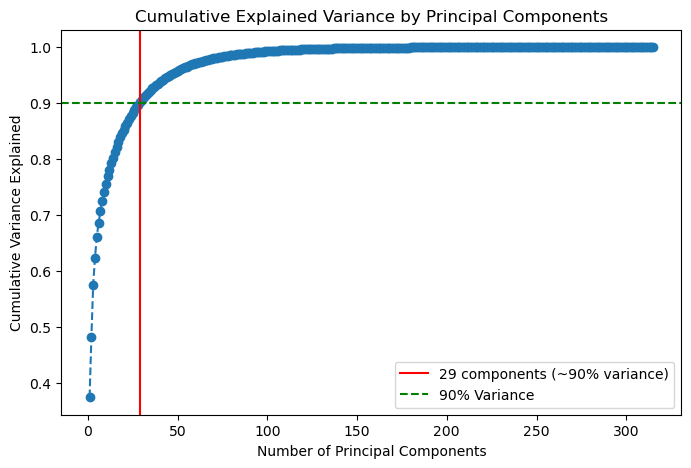

In [13]:
cumulative_variance = pca.explained_variance_ratio_.cumsum()

magic_n_components = np.argmax(cumulative_variance >= 0.9) + 1

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(x=magic_n_components, color='r', linestyle='-', linewidth=1.5, label=f'{magic_n_components} components (~90% variance)')
plt.axhline(y=0.90, color='g', linestyle='--', linewidth=1.5, label='90% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.show()


From these plots we can see that taking only 29 components out the 315 features explains around 90% of the variance of the data.

Finally, we can see how these principal componets are built out of the different features by plotting the contribution of each feature in a bar plot

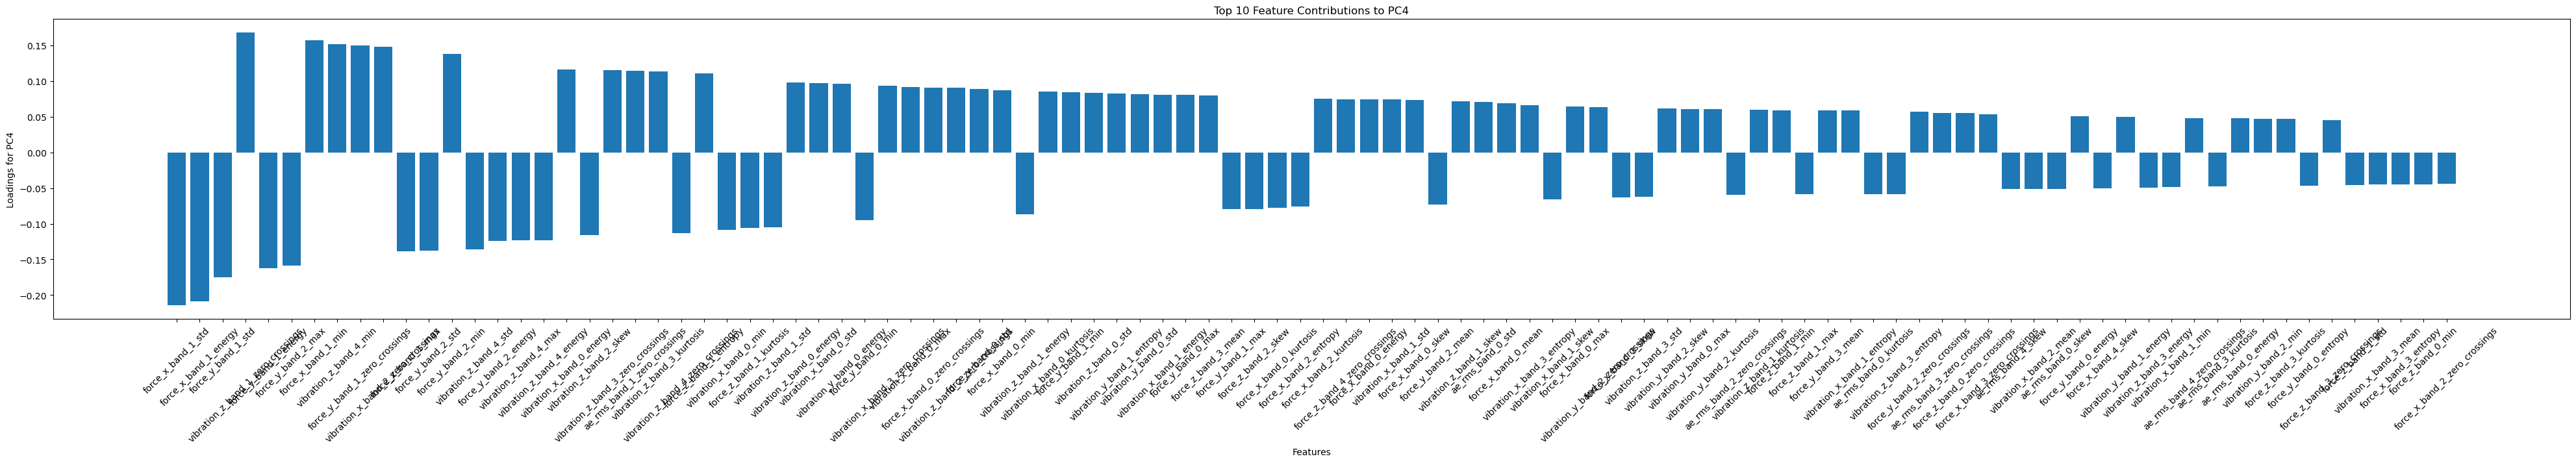

In [14]:
pc_index = 3  # 0 for PC1, 1 for PC2, etc.
pc_loadings = pca.components_[pc_index]

loadings_df = pd.DataFrame({
    'Feature': df_features_full.columns,
    'Loading': pc_loadings
})

# Sort features by the absolute value of their loadings in descending order
top_features = loadings_df.reindex(loadings_df['Loading'].abs().sort_values(ascending=False).index).head(100)

# Create a bar plot for the top 10 features
plt.figure(figsize=(50, 6))
plt.bar(x=top_features['Feature'], height=top_features['Loading'])
plt.xlabel('Features')
plt.ylabel(f'Loadings for PC{pc_index + 1}')
plt.title(f'Top 10 Feature Contributions to PC{pc_index + 1}')
plt.xticks(rotation=45)
#plt.grid(True)
plt.show()

Components that don't add much to the variance of the signal might still be useful for prediction purposes, so this is only an idea worth trying.